# DCGAN的编程

实现DCGAN网络并学习DCGAN。


#  学习目标

1.	理解生成器生成图像的机制与其网络构造之间的联系。
2.	理解判别器对图像进行判断的机制与其网络构造之间的联系。
3.	理解 GAN 常用的损失函数的实现及其神经网络学习的流程。
4.	掌握编程实现 DCGAN 网络的方法。


# 学习目标

1.	理解 GAN 中使用的损失函数。
2.	编程实现 DCGAN，并完成手写数字图像7、8的自动生成。


In [1]:
# 导入软件包
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Generator的实现

In [3]:
class Generator(nn.Module):
    '''
        实现生成器，注意利用转置卷积或微步卷积升维，生成64*64的灰度图像
    '''
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(z_dim, 8*image_size, kernel_size=4, stride=1)
        self.deconv2 = nn.ConvTranspose2d(8*image_size, 4*image_size, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(4*image_size, 2*image_size, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(2*image_size, image_size, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(8*image_size)
        self.bn2 = nn.BatchNorm2d(4*image_size)
        self.bn3 = nn.BatchNorm2d(2*image_size)
        self.bn4 = nn.BatchNorm2d(image_size)
        
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
              
    def forward(self, z):
        x = self.relu(self.bn1(self.deconv1(z)))
        x = self.relu(self.bn2(self.deconv2(x)))
        x = self.relu(self.bn3(self.deconv3(x)))
        x = self.relu(self.bn4(self.deconv4(x)))
        x = self.tanh(self.deconv5(x))
        
        return x

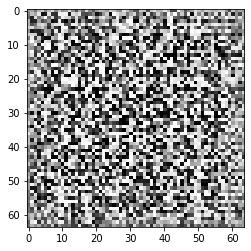

In [4]:
# 生成器测试
import matplotlib.pyplot as plt

# 告诉jupyter显示图形而不是弹出窗口
%matplotlib inline  

G = Generator(z_dim=20, image_size=64)

# 输入的随机数
input_z = torch.randn(1, 20)

# 将张量尺寸变形为(1,20,1,1)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# print(input_z.size())

# 输出假图像
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# Discriminator的实现

In [5]:
class Discriminator(nn.Module):

    '''
        实现辨别器
    '''
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(image_size, 2*image_size, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(2*image_size, 4*image_size, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(4*image_size, 8*image_size, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(8*image_size, 1, kernel_size=4, stride=1)
        
        self.leakyRelu = nn.LeakyReLU(0.1, inplace=True)
        
    def forward(self, x):
        x = self.leakyRelu(self.conv1(x))
        x = self.leakyRelu(self.conv2(x))
        x = self.leakyRelu(self.conv3(x))
        x = self.leakyRelu(self.conv4(x))
        
        feature = x
        feature = feature.view(feature.size()[0], -1)
        
        x = self.conv5(x)
        
        return x

In [6]:
# 辨别器测试
D = Discriminator(z_dim=20, image_size=64)

# 生成伪造图像
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 将伪造的图像输入判别器D中
d_out = D(fake_images)

# 将输出值d_out乘以Sigmoid函数，将其转换成0～1的值
print(nn.Sigmoid()(d_out))

tensor([[[[0.5066]]]], grad_fn=<SigmoidBackward>)


# GAN 的损失函数

# DataLoader 的实现

In [7]:
def make_datapath_list():
    """创建用于学习和验证的图像数据及标注数据的文件路径列表。 """

    train_img_list = list()  # 保存图像文件的路径

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [8]:
class ImageTransform():
    """图像的预处理类"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [9]:
class GAN_Img_Dataset(data.Dataset):
    """图像的 Dataset 类，继承自 PyTorch 的 Dataset 类"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''返回图像的张数'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''获取经过预处理后的图像的张量格式的数据'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [ 高度 ][ 宽度 ] 黑白

        # 图像的预处理
        img_transformed = self.transform(img)

        return img_transformed

In [10]:
# 创建DataLoader并确认执行结果

# 创建文件列表
train_img_list=make_datapath_list()

# 创建Dataset
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# 创建DataLoader
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 确认执行结果
batch_iterator = iter(train_dataloader)  #转换为迭代器
imges = next(batch_iterator)  
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


#  DCGAN的学习

In [11]:
# 网络的初始化处理
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2d和ConvTranspose2d的初始化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d的初始化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 开始初始化
G.apply(weights_init)
D.apply(weights_init)

print("网络已经成功地完成了初始化")

网络已经成功地完成了初始化


In [12]:
def train_model(G, D, dataloader, num_epochs):

    # 确认是否能够使用GPU加速
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用设备：", device)

    # 设置最优化算法
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 定义误差函数
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 使用硬编码的参数
    z_dim = 20
    mini_batch_size = 64

    # 将网络载入GPU中
    G.to(device)
    D.to(device)

    G.train()  # 将模式设置为训练模式
    D.train()  # 将模式设置为训练模式

    # 如果网络相对固定，则开启加速
    torch.backends.cudnn.benchmark = True

    # 图像张数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 设置迭代计数器
    iteration = 1
    logs = []

    # epoch循环
    for epoch in range(num_epochs):

        # 保存开始时间
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch的损失总和
        epoch_d_loss = 0.0  # epoch的损失总和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # 以minibatch为单位从数据加载器中读取数据的循环
        for images in dataloader:

            # --------------------
            # 1.判别器D的学习
            # --------------------
            # 如果小批次的尺寸设置为1，会导致批次归一化处理产生错误，因此需要避免
            if images.size()[0] == 1:
                continue

            # 如果能使用GPU，则将数据送入GPU中
            images = images.to(device)
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1, dtype=torch.float).to(device)
            label_fake = torch.full((mini_batch_size,), 0, dtype=torch.float).to(device)
            # 创建正确答案标签和伪造数据标签
            # 在epoch最后的迭代中，小批次的数量会减少

            # 对真正的图像进行判定
            d_out_real = D(images)

            # 生成伪造图像并进行判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 计算误差
            '''
                完成loss代码
            '''
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 反向传播处理
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2.生成器G的学习
            # --------------------
            # 生成伪造图像并进行判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 计算误差
            '''
                完成loss代码
            '''
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 反向传播处理
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3.记录结果
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch的每个phase的loss和准确率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

In [13]:
# 执行学习和验证操作
num_epochs = 200
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用设备： cuda:0
-------------
Epoch 0/200
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1051 ||Epoch_G_Loss:0.0899
timer:  11.2961 sec.
-------------
Epoch 1/200
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0470 ||Epoch_G_Loss:0.2693
timer:  4.7610 sec.
-------------
Epoch 2/200
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.2460 ||Epoch_G_Loss:0.4167
timer:  4.8220 sec.
-------------
Epoch 3/200
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0177 ||Epoch_G_Loss:0.2695
timer:  4.8355 sec.
-------------
Epoch 4/200
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0038 ||Epoch_G_Loss:0.4330
timer:  4.8200 sec.
-------------
Epoch 5/200
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0015 ||Epoch_G_Loss:0.5440
timer:  4.9090 sec.
-------------
Epoch 6/200
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.1193 ||Epoch_G_Loss:0.6050
timer:  6.0140 sec.
-------------
Epoch 7/200
-------------
（

-------------
epoch 60 || Epoch_D_Loss:0.1063 ||Epoch_G_Loss:0.1465
timer:  7.2150 sec.
-------------
Epoch 61/200
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.0955 ||Epoch_G_Loss:0.1894
timer:  6.3000 sec.
-------------
Epoch 62/200
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.0838 ||Epoch_G_Loss:0.1704
timer:  6.0900 sec.
-------------
Epoch 63/200
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.0998 ||Epoch_G_Loss:0.1815
timer:  6.0460 sec.
-------------
Epoch 64/200
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.0814 ||Epoch_G_Loss:0.1784
timer:  6.4573 sec.
-------------
Epoch 65/200
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.0914 ||Epoch_G_Loss:0.1753
timer:  6.4100 sec.
-------------
Epoch 66/200
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.0860 ||Epoch_G_Loss:0.1884
timer:  6.4100 sec.
-------------
Epoch 67/200
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.2497
timer:  6.3850 sec.
-------------
Epoch 121/200
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0547 ||Epoch_G_Loss:0.2875
timer:  6.2180 sec.
-------------
Epoch 122/200
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0604 ||Epoch_G_Loss:0.2849
timer:  6.0600 sec.
-------------
Epoch 123/200
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0661 ||Epoch_G_Loss:0.2642
timer:  6.1779 sec.
-------------
Epoch 124/200
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0682 ||Epoch_G_Loss:0.2806
timer:  5.9440 sec.
-------------
Epoch 125/200
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0599 ||Epoch_G_Loss:0.2973
timer:  6.0042 sec.
-------------
Epoch 126/200
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0453 ||Epoch_G_Loss:0.3046
timer:  6.5372 sec.
-------------
Epoch 127/200
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0472 ||Epoch_G_Loss:0.4268
timer:  6.2500 sec.
-------------
Epoch 180/200
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0295 ||Epoch_G_Loss:0.4124
timer:  6.3120 sec.
-------------
Epoch 181/200
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0269 ||Epoch_G_Loss:0.4966
timer:  5.8900 sec.
-------------
Epoch 182/200
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0263 ||Epoch_G_Loss:0.4212
timer:  6.0610 sec.
-------------
Epoch 183/200
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0536 ||Epoch_G_Loss:0.4383
timer:  6.5970 sec.
-------------
Epoch 184/200
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0184 ||Epoch_G_Loss:0.4596
timer:  6.1880 sec.
-------------
Epoch 185/200
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0272 ||Epoch_G_Loss:0.4382
timer:  6.1400 sec.
-------------
Epoch 186/200
-------------
（train）
-------------
epoch 186 || 

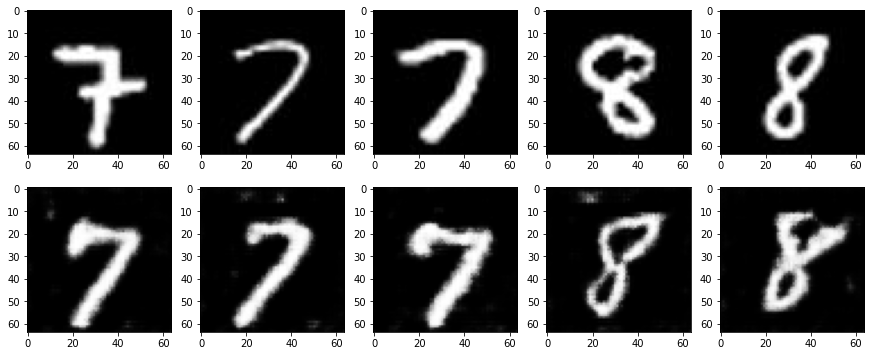

In [26]:
# 将生成的图像和训练数据可视化
# 反复执行本单元中的代码，直到生成感觉良好的图像为止

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 生成用于输入的随机数
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 生成图像
fake_images = G_update(fixed_z.to(device))

# 训练数据
batch_iterator = iter(train_dataloader)  # 转换成迭代器
imges = next(batch_iterator)  # 取出位于第一位的元素


# 输出结果
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 将训练数据放入上层
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 将生成数据放入下层
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')